<a href="https://colab.research.google.com/github/matsu2254/study/blob/main/material/20240112_pandas_nyumon/notebook/zissen2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実践応用（２）

習うより慣れろ！

ということで、公開されているFXチャートデータをデータフレームとして読み込み、前処理や描写をやってみる。

- mplfinane
  - mplfinaceはmatplotlib風の金融向けグラフ描写ライブラリ
  - キャンドルチャートなどがかける
- pandas_ta
  - pandas_ta（テクニカルアナライズ）は、pandasの時系列データから、金融向けのインジケータやチャートパターンを検出できる！！（なんかすごそう（小並感
  - 類似としてtalib


https://github.com/twopirllc/pandas-ta/pull/693

https://github.com/matplotlib/mplfinance/blob/master/examples/external_axes.ipynb


In [1]:
! pip install pandas_ta mplfinance

import pandas as pd
import mplfinance as mpf
import pandas_ta as ta
import numpy as np

import shutil
import requests


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.4 MB/s eta 0:00:00
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=b7b1e0e37566d85448cff7a824be69a6d2091bb989d350a7a7bbf96337b52f87
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
# データの取得
# 時間がかかる
r = requests.get('https://forextester.com/templates/data/files/GBPJPY.zip')
with open('GBPJPY.zip', 'wb') as f:
  f.write(r.content)

# データの解凍
shutil.unpack_archive('GBPJPY.zip')

In [4]:
# 解凍したデータの読み込み
odf  = pd.read_csv(
      'GBPJPY.txt',
       parse_dates=[['<DTYYYYMMDD>','<TIME>']]
    ).set_index('<DTYYYYMMDD>_<TIME>')

# 適当に用意しておいた予測データのインポート
predict_df = pd.read_pickle('https://raw.githubusercontent.com/matsu2254/study/main/material/20240112_pandas_nyumon/notebook/greykite_predict_GBPJPY.pickle').set_index('<DTYYYYMMDD>_<TIME>')

odf

,<TICKER>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DTYYYYMMDD>_<TIME>,,,,,,
2001-01-02 23:01:00,GBPJPY,171.88,171.88,171.86,171.86,4
2001-01-02 23:02:00,GBPJPY,171.86,171.87,171.86,171.87,4
2001-01-02 23:03:00,GBPJPY,171.87,171.87,171.87,171.87,4
2001-01-02 23:04:00,GBPJPY,171.87,171.88,171.87,171.88,4
2001-01-02 23:05:00,GBPJPY,171.88,171.88,171.88,171.88,4
...,...,...,...,...,...,...
2023-11-30 23:55:00,GBPJPY,186.81,186.81,186.81,186.81,4
2023-11-30 23:56:00,GBPJPY,186.79,186.79,186.79,186.79,4
2023-11-30 23:57:00,GBPJPY,186.80,186.80,186.80,186.80,4


In [5]:
# 列のリネーム
odf.columns = ['Ticker','Open','High','Low','Close','Vol']
odf

,Ticker,Open,High,Low,Close,Vol
<DTYYYYMMDD>_<TIME>,,,,,,
2001-01-02 23:01:00,GBPJPY,171.88,171.88,171.86,171.86,4
2001-01-02 23:02:00,GBPJPY,171.86,171.87,171.86,171.87,4
2001-01-02 23:03:00,GBPJPY,171.87,171.87,171.87,171.87,4
2001-01-02 23:04:00,GBPJPY,171.87,171.88,171.87,171.88,4
2001-01-02 23:05:00,GBPJPY,171.88,171.88,171.88,171.88,4
...,...,...,...,...,...,...
2023-11-30 23:55:00,GBPJPY,186.81,186.81,186.81,186.81,4
2023-11-30 23:56:00,GBPJPY,186.79,186.79,186.79,186.79,4
2023-11-30 23:57:00,GBPJPY,186.80,186.80,186.80,186.80,4


In [6]:
# 4時間足にリサンプル、列ごとに区間のどこのデータを使うか定義

d_ohlc = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
        }

# locでデータをスライスする
# resample, aggでデータを４時間ごとに変換
# resampleでサンプルし直す時間を指定
# aggで各列を集約する関数を指定

df = odf.loc['2023-04-01':'2023-04-30'].resample('4H').agg(d_ohlc)

# 同じようにスライスする
p_df = predict_df.loc['2021-04-01':'2023-04-30']

# 予測データともとデータの結合
df  = pd.merge(df,p_df,on='<DTYYYYMMDD>_<TIME>',how='left')

# 空白をうめる
df[['forecast','forecast_upper','forecast_lower']] = df[['forecast','forecast_upper','forecast_lower']].fillna(method='ffill')

df

,Open,High,Low,Close,actual,forecast,forecast_lower,forecast_upper
<DTYYYYMMDD>_<TIME>,,,,,,,,
2023-04-02 20:00:00,164.29,164.29,163.40,163.56,NaN,NaN,NaN,NaN
2023-04-03 00:00:00,163.68,163.98,163.51,163.92,164.86,165.386078,164.305086,166.467071
2023-04-03 04:00:00,163.93,164.70,163.88,164.63,NaN,165.386078,164.305086,166.467071
2023-04-03 08:00:00,164.64,164.86,164.41,164.57,NaN,165.386078,164.305086,166.467071
2023-04-03 12:00:00,164.56,164.58,163.75,164.18,NaN,165.386078,164.305086,166.467071
...,...,...,...,...,...,...,...,...
2023-04-30 04:00:00,NaN,NaN,NaN,NaN,NaN,170.528743,168.920586,172.136901
2023-04-30 08:00:00,NaN,NaN,NaN,NaN,NaN,170.528743,168.920586,172.136901
2023-04-30 12:00:00,NaN,NaN,NaN,NaN,NaN,170.528743,168.920586,172.136901


In [7]:
# インジケータの用意
# 表題のセルに貼っているURLを参照

rsi = ta.momentum.rsi(df['Close'],length=3)
psar = ta.trend.psar(high=df['High'],low=df['Low'])

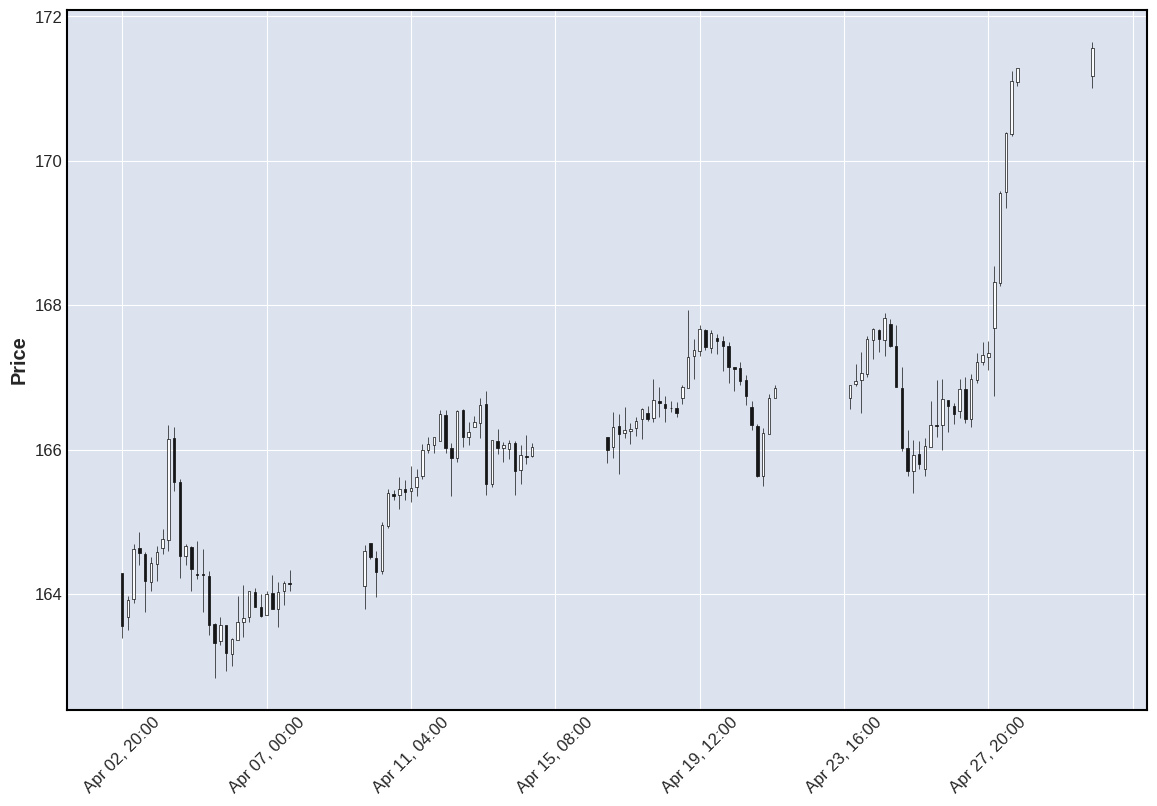

In [8]:
# 一番簡単な例
mpf.plot(df,type='candle',figsize=(15,10))

[171.65, 171.29, 167.93]


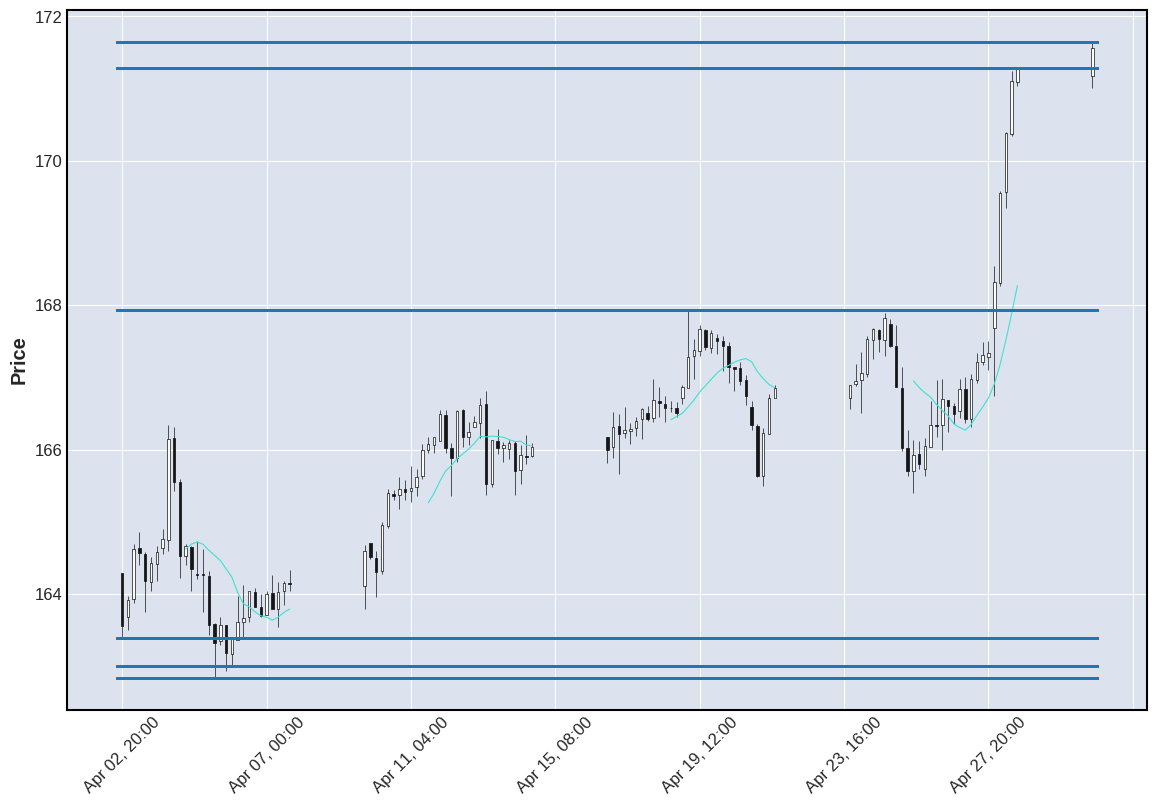

In [20]:
# 水平線を引く

# df['High'].resample('d').max().nlargest(n=3).values.tolist()
# 'High'列を抜き出し、最大値で集約、日次のデータにする。
# そのデータから大きい方から３つ取得し、リストにする。

print (df['High'].resample('d').max().nlargest(n=3).values.tolist())

mpf.plot(
        df,
        type='candle',
        figsize=(15,10),
        mav=12,
        hlines=df['High'].resample('d').max().nlargest(n=3).values.tolist()
                + df['Low'].resample('d').min().nsmallest(n=3).values.tolist()
        )

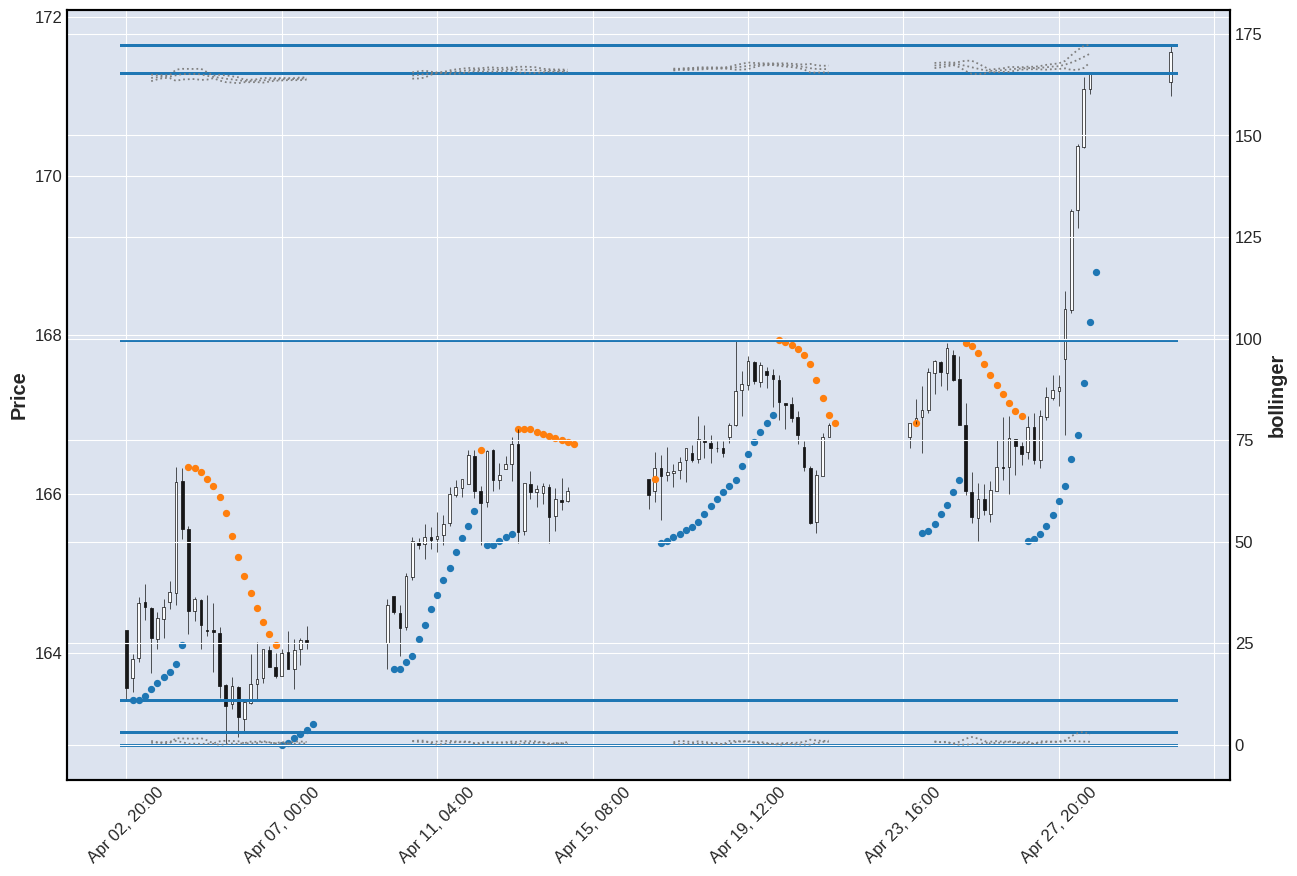

In [10]:
# matplotlib的な書き方で、PSARを描写する
fig = mpf.figure(figsize=(15,10))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
op = [
      mpf.make_addplot(psar['PSARl_0.02_0.2'],ax=ax1,type='scatter'),
      mpf.make_addplot(psar['PSARs_0.02_0.2'],ax=ax1,type='scatter'),
      mpf.make_addplot(df.ta.bbands(),ax=ax2,ylabel='bollinger',type='line',color='grey',linestyle='dotted'),
      ]

mpf.plot(
         df,
         type='candle',
         ax=ax1,
         addplot=op,
         hlines=df['High'].resample('d').max().nlargest(n=3).values.tolist()
                + df['Low'].resample('d').min().nsmallest(n=3).values.tolist()
        )

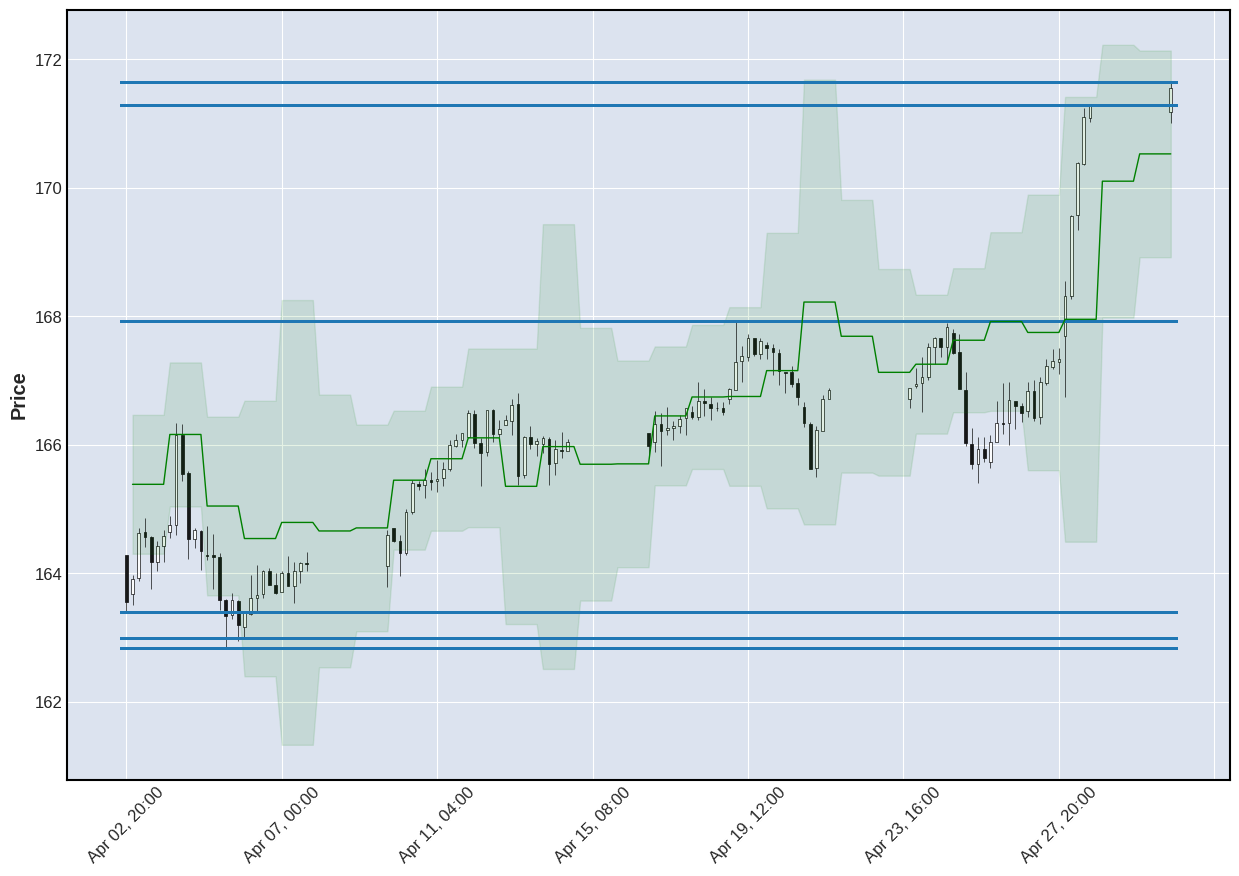

In [15]:
# greykiteで4h*4本分の予測をプロット、95％信頼区間を描写

fig2 = mpf.figure(figsize=(15,10))
ax21 = fig2.add_subplot()

op2 = [
    mpf.make_addplot(
                    df['forecast'],
                    ax=ax21,
                    type='line',
                    color='green',
                    width=1,
                    fill_between=dict(y1=df['forecast_upper'].values,y2=df['forecast_lower'].values,alpha=0.1,color='green')
                    )
]

mpf.plot(
    df,
    type='candle',
    ax=ax21,
    addplot=op2,
    hlines=df['High'].resample('d').max().nlargest(n=3).values.tolist()
                + df['Low'].resample('d').min().nsmallest(n=3).values.tolist()
    )


In [16]:
df.describe()

,Open,High,Low,Close,actual,forecast,forecast_lower,forecast_upper
count,121.000000,121.000000,121.000000,121.00000,24.000000,168.000000,168.000000,168.000000
mean,165.991488,166.281074,165.731983,166.05000,166.776667,166.595072,164.748250,168.441895
std,1.493197,1.535914,1.525014,1.57371,1.829059,1.507767,1.646090,1.740621
min,163.170000,163.400000,162.840000,163.19000,164.130000,164.542373,161.331785,166.315844
25%,164.710000,165.000000,164.490000,164.76000,166.040000,165.434182,163.637537,167.188495
50%,166.160000,166.390000,165.940000,166.17000,166.700000,166.306284,164.740375,168.004860
75%,166.720000,167.010000,166.520000,166.86000,167.525000,167.643988,165.577392,169.341159
max,171.180000,171.650000,171.030000,171.56000,171.650000,170.528743,168.920586,172.226170


In [18]:
# ライブラリの機能説明
# 対数リターンの取得
df.ta.log_return(cumulative=True,append=True)

<DTYYYYMMDD>_<TIME>
2023-04-02 20:00:00    0.000000
2023-04-03 00:00:00    0.002199
2023-04-03 04:00:00    0.006521
2023-04-03 08:00:00    0.006156
2023-04-03 12:00:00    0.003783
                         ...   
2023-04-30 04:00:00         NaN
2023-04-30 08:00:00         NaN
2023-04-30 12:00:00         NaN
2023-04-30 16:00:00         NaN
2023-04-30 20:00:00    0.047753
Name: CUMLOGRET_1, Length: 169, dtype: float64

In [19]:
# 機能説明２
df.ta.percent_return(cumulatative=True,append=True)

<DTYYYYMMDD>_<TIME>
2023-04-02 20:00:00         NaN
2023-04-03 00:00:00    0.002201
2023-04-03 04:00:00    0.004331
2023-04-03 08:00:00   -0.000364
2023-04-03 12:00:00   -0.002370
                         ...   
2023-04-30 04:00:00    0.000000
2023-04-30 08:00:00    0.000000
2023-04-30 12:00:00    0.000000
2023-04-30 16:00:00    0.000000
2023-04-30 20:00:00    0.001576
Name: PCTRET_1, Length: 169, dtype: float64

In [ ]:
# 機能説明３
df.ta.bbands()

,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0
<DTYYYYMMDD>_<TIME>,,,,,
2023-04-02 20:00:00,NaN,NaN,NaN,NaN,NaN
2023-04-03 00:00:00,NaN,NaN,NaN,NaN,NaN
2023-04-03 04:00:00,NaN,NaN,NaN,NaN,NaN
2023-04-03 08:00:00,NaN,NaN,NaN,NaN,NaN
2023-04-03 12:00:00,163.368866,164.172,164.975134,0.978405,0.50498
...,...,...,...,...,...
2023-04-30 04:00:00,NaN,NaN,NaN,NaN,NaN
2023-04-30 08:00:00,NaN,NaN,NaN,NaN,NaN
2023-04-30 12:00:00,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 高値を上から３つ取り出し、リストにする
df['High'].nlargest(n=3).values.tolist()

[171.65, 171.29, 171.24]

In [ ]:
# 愚直にトレンド転換点を記録する

# .iterrows()で添字と、行を取り出す

f=False
for index, row in psar.iterrows():
    if pd.notnull(row['PSARl_0.02_0.2']) and not f:
        f=True
        psar.at[index,'Trend']='Long'
        psar.at[index,'TPrice']=row['PSARl_0.02_0.2']
    elif pd.notnull(row['PSARs_0.02_0.2']) and f:
        f=False
        psar.at[index,'Trend']='Short'
        psar.at[index,'TPrice']=row['PSARs_0.02_0.2']
    else:
        psar.at[index,'Trend']='None'
        psar.at[index,'TPrice']=np.nan

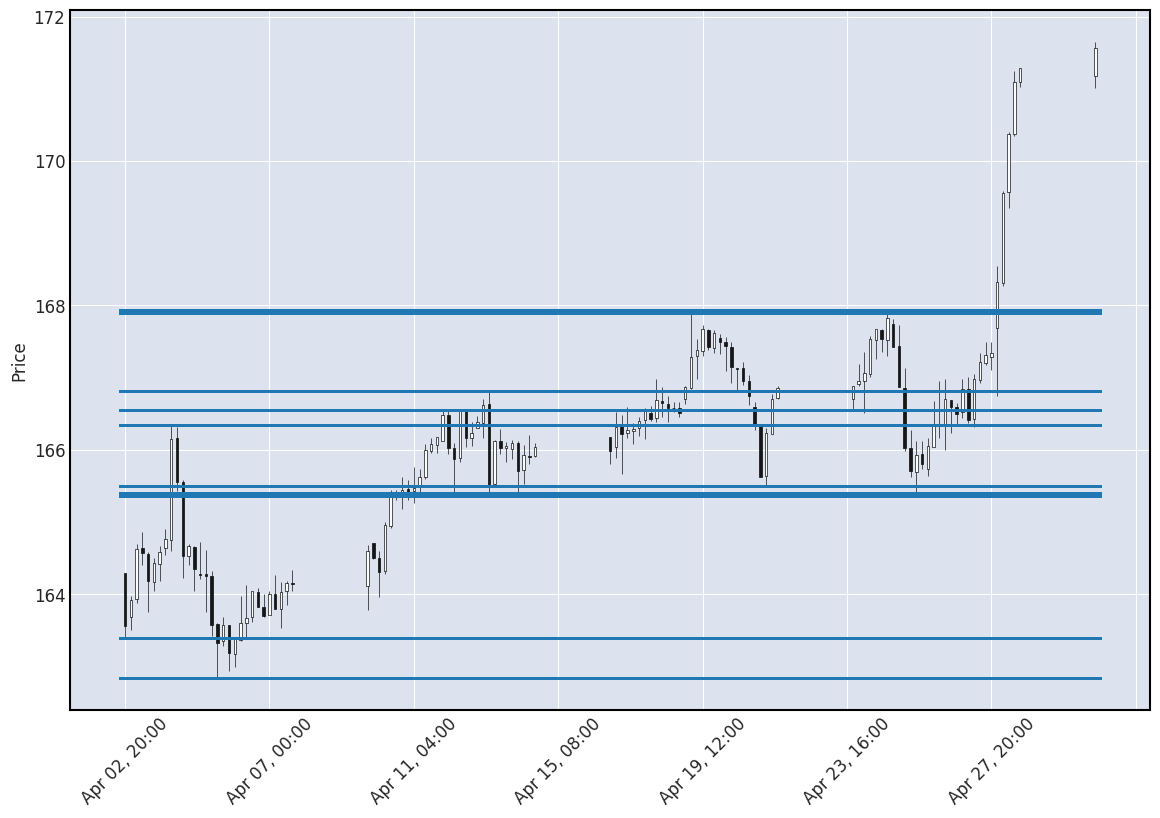

[163.4,
 166.34,
 162.84,
 166.55,
 165.36,
 166.81,
 165.38,
 167.93,
 165.5,
 167.9,
 165.4]

In [ ]:
df_2 = odf.loc['2023-04-01':'2023-04-30'].resample('4H').agg(d_ohlc)

mpf.plot(
    df,
    figsize=(15,10),
    type='candle',
    hlines=psar['TPrice'].dropna().tolist()
    )
psar['TPrice'].dropna().tolist()

In [ ]:
df.to_csv('./savefile.csv')